In [1]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

In [23]:
# Load data

# bus - passengers transported, average transport distance
bus_df = pd.read_excel('bus_orig.xlsx', index_col=[0, 1], usecols='A:G, M', skiprows=9)
bus_df.iloc[:, :-1] = bus_df.iloc[:, :-1]/1000  # passengers in millions
bus_df.columns = [
    'total_mil', 'scheduled_total_mil', 'scheduled_national_mil',
    'scheduled_iternational_mil', 'non-scheduled_mil', 'average_dist_km'
]
bus_df = bus_df.iloc[8:87]

# rail - passengers transported, average transport distance
rail_df = pd.read_excel('rail_orig.xlsx', index_col=[0, 1], usecols='A:C,E', skiprows=9)
rail_df.iloc[:, 0] = rail_df.iloc[:, 0]/1000  # passengers in millions
rail_df.columns = ['total_mil', 'average_dist_km']
rail_df = rail_df.iloc[8:87]

# airplane - Czech transport companies only
plane_df = pd.read_excel('plane_orig.xlsx', index_col=[0, 1], usecols='A:G, M', skiprows=7)
plane_df = plane_df.iloc[8:87,[5]]  # select only distance
plane_df.columns = ['average_dist_km']

# airplane - Eurostat CZ
plane_eur_df = pd.read_excel('avia_paoc__custom_2012682_spreadsheet.xlsx',
                             sheet_name='all_sheets', index_col=0, header=0).T
plane_eur_df = plane_eur_df.iloc[4:87]/1e6  # in millions of passengers
plane_eur_df.columns.name = ''
plane_eur_df.columns = [i + '_mil' for i in plane_eur_df.columns]

dflist = [bus_df, rail_df, plane_df, plane_eur_df]

In [24]:
# set new index as DatetimeIndex
new_index = pd.date_range(start='2002-01-01', end='2021-09-30', freq='Q')
for i in dflist:
    i.index = new_index
    i.index.name = 'Year'

In [28]:
# show data
#for i, name in zip(dflist, ['bus_df', 'rail_df', 'plane_df', 'plane_eur_df']):
#    print(name + ':')
#    display(round(i.iloc[[0,1,-2,-1]],2))

In [29]:
mpl.rc('figure', figsize=(12,6))
mpl.rc('axes', labelsize=16, titlesize=20)
mpl.rc('lines', linewidth=2)
mpl.rc('legend', fontsize=14, title_fontsize=14)

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # colors
cmn_kwargs = {'grid': True, 'legend': True}

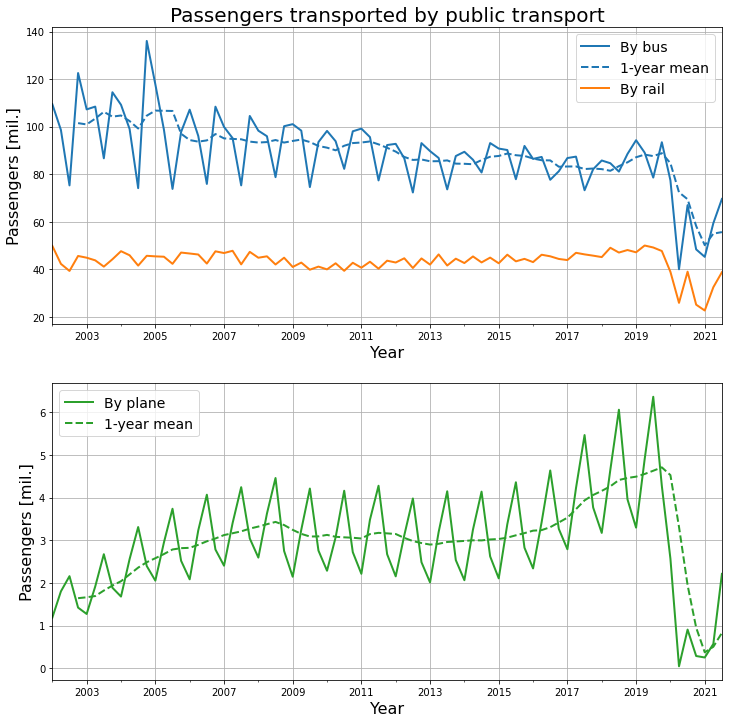

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

# passengers transported
bus_df['total_mil'].plot(ax=ax1, **cmn_kwargs)
bus_df['total_mil'].rolling(4).mean().plot(ax=ax1, c=c[0], ls='dashed', **cmn_kwargs)
rail_df['total_mil'].plot(ax=ax1, **cmn_kwargs)
ax1.legend(['By bus', '1-year mean', 'By rail'])
ax1.set_title('Passengers transported by public transport')

plane_eur_df['Total-total_mil'].plot(ax=ax2, c=c[2], **cmn_kwargs)
(plane_eur_df['Total-total_mil'].rolling(4).mean()
 .plot(ax=ax2, c=c[2], ls='dashed', **cmn_kwargs))
ax2.legend(['By plane', '1-year mean'], loc='upper left')

for i in (ax1, ax2):
    i.set_ylabel('Passengers [mil.]')

In [40]:
# total passengers - shares of each transport type by year
share_df = (
    bus_df[['total_mil']]
    .join(rail_df['total_mil'], rsuffix='_rail')
    .join(plane_eur_df['Total-total_mil']))
share_df.columns = ['total_mil_bus',
                    'total_mil_rail',
                    'total_mil_plane']
share_df = share_df.groupby(share_df.index.year).sum()
share_df['sum'] = share_df.sum(axis=1)
share_df['Bus share'] = share_df['total_mil_bus']/share_df['sum']*100
share_df['Rail share'] = share_df['total_mil_rail']/share_df['sum']*100
share_df['Plane share'] = share_df['total_mil_plane']/share_df['sum']*100
share_df.head(3).round(1)

,total_mil_bus,total_mil_rail,total_mil_plane,sum,Bus share,Rail share,Plane share
Year,,,,,,,
2002,406.1,177.2,6.6,589.9,68.8,30.0,1.1
2003,417.0,174.2,7.8,599.0,69.6,29.1,1.3
2004,418.6,180.9,10.0,609.5,68.7,29.7,1.6


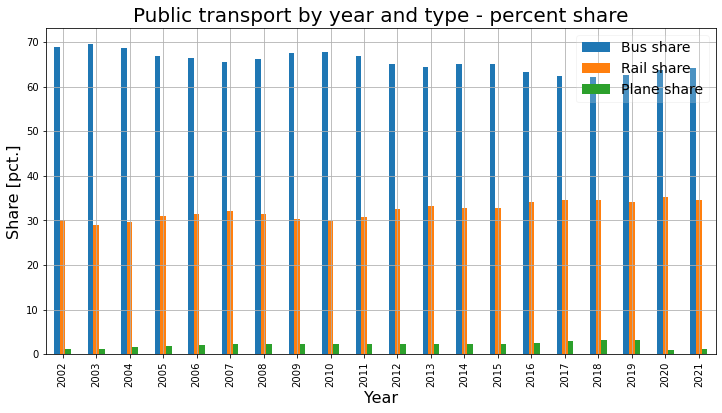

In [41]:
fig, ax = plt.subplots(1,1)
share_df.iloc[:,4:].plot.bar(ax=ax, **cmn_kwargs)
ax.legend(framealpha=0.2)
ax.set_title('Public transport by year and type - percent share')
ax.set_ylabel('Share [pct.]')
plt.show()

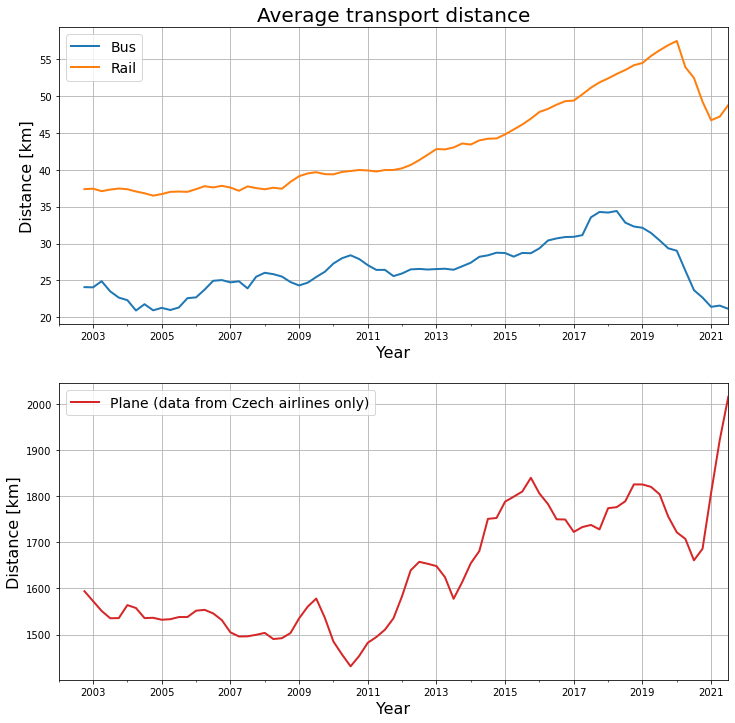

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))

for i in [bus_df, rail_df]:
    i['average_dist_km'].rolling(4).mean().plot(ax=ax1, **cmn_kwargs)
ax1.legend(['Bus', 'Rail'])
ax1.set_title('Average transport distance')
ax1.set_ylabel('Distance [km]')

(plane_df['average_dist_km']
 .rolling(4).mean()
 .plot(ax=ax2, c=c[3], **cmn_kwargs))
ax2.legend(['Plane (data from Czech airlines only)'], loc='upper left')
ax2.set_ylabel('Distance [km]')

for i in (ax1, ax2):
    i.set_xlabel('Year')
    i.set_ylabel('Distance [km]')
plt.show()